# Musik dan Kesehatan Mental: Menjelajahi Dampak Kebiasaan Mendengarkan Musik

In [722]:
# Impor pustaka
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, output_file
from bokeh.models import ColumnDataSource, Select, Slider, CustomJS, HoverTool, ColorBar, LinearColorMapper
from bokeh.layouts import column, row
from bokeh.palettes import Turbo256, Viridis256
from bokeh.models import FactorRange
from bokeh.transform import cumsum, transform
from math import pi
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [723]:
# Aktifkan output Bokeh di Jupyter Notebook
output_notebook()

Loading BokehJS ...

In [ ]:
# Muat dataset
df = pd.read_csv('../data/mxmh_survey_results.csv')

In [725]:
# Bersihkan data: Hapus baris dengan nilai hilang di kolom penting
df = df.dropna(subset=['Age', 'Hours per day', 'Anxiety', 'Depression', 'Insomnia', 'OCD', 'Primary streaming service', 'Fav genre', 'Music effects'])

# --- VISUALISASI 1: Scatter Plot Interaktif ---

In [726]:
# Buat pemetaan warna untuk genre
genres = df['Fav genre'].unique()
num_genres = len(genres)
colors = Turbo256[:num_genres]  # Ambil 16 warna dari Turbo256
genre_color_map = dict(zip(genres, colors))

In [727]:
# Tambahkan kolom 'color' ke DataFrame
df['color'] = df['Fav genre'].map(genre_color_map)

In [728]:
# Verifikasi kolom 'color'
print("Kolom dalam df:", df.columns.tolist())
print("Contoh data kolom 'color':", df['color'].head())

Kolom dalam df: ['Timestamp', 'Age', 'Primary streaming service', 'Hours per day', 'While working', 'Instrumentalist', 'Composer', 'Fav genre', 'Exploratory', 'Foreign languages', 'BPM', 'Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]', 'Anxiety', 'Depression', 'Insomnia', 'OCD', 'Music effects', 'Permissions', 'color']
Contoh data kolom 'color': 2    #30123b
3    #311542
4    #32184a
5    #311542
6    #30123b
Name: color, dtype: object


In [729]:
# Buat ColumnDataSource
source = ColumnDataSource(data={
    'x': df['Hours per day'],
    'y': df['Anxiety'],
    'genre': df['Fav genre'],
    'age': df['Age'],
    'streaming': df['Primary streaming service'],
    'color': df['color']
})

In [730]:
# Buat scatter plot
p = figure(title="Jam Mendengarkan Musik vs. Kecemasan Berdasarkan Genre",
           x_axis_label="Jam per Hari", y_axis_label="Kecemasan (0-25)",
           tools="pan,box_zoom,reset,save", width=600, height=400)

p.scatter('x', 'y', source=source, size=8, color='color', legend_field='genre', alpha=0.7)

GlyphRenderer(id='p3746', ...)

In [731]:
# Tambahkan hover tool
hover = HoverTool(tooltips=[("Genre", "@genre"), ("Jam/Hari", "@x"), ("Kecemasan", "@y")])
p.add_tools(hover)

In [732]:
# Buat widget interaktif
streaming_options = df['Primary streaming service'].unique().tolist()
select_streaming = Select(title="Layanan Streaming", value="Semua", options=["Semua"] + streaming_options)
age_slider = Slider(title="Usia Maksimum", start=df['Age'].min(), end=df['Age'].max(), value=df['Age'].max(), step=1)

In [733]:
# Callback JavaScript untuk interaktivitas
callback = CustomJS(args=dict(source=source, select=select_streaming, slider=age_slider, orig_data=source.data),
                    code="""
    const data = {...orig_data};
    const streaming = select.value;
    const max_age = slider.value;
    let filtered_x = [];
    let filtered_y = [];
    let filtered_genre = [];
    let filtered_age = [];
    let filtered_streaming = [];
    let filtered_color = [];
    
    for (let i = 0; i < data.x.length; i++) {
        if ((streaming === "Semua" || data.streaming[i] === streaming) && data.age[i] <= max_age) {
            filtered_x.push(data.x[i]);
            filtered_y.push(data.y[i]);
            filtered_genre.push(data.genre[i]);
            filtered_age.push(data.age[i]);
            filtered_streaming.push(data.streaming[i]);
            filtered_color.push(data.color[i]);
        }
    }
    
    source.data = {
        x: filtered_x,
        y: filtered_y,
        genre: filtered_genre,
        age: filtered_age,
        streaming: filtered_streaming,
        color: filtered_color
    };
    source.change.emit();
""")

In [734]:
# Hubungkan callback ke widget
select_streaming.js_on_change('value', callback)
age_slider.js_on_change('value', callback)

In [735]:
# Tata letak
layout = column(row(select_streaming, age_slider), p)

In [ ]:
# Simpan sebagai HTML
output_file("../docs/scatter_musik_kecemasan.html")
show(layout)

# --- VISUALISASI 2: Diagram Batang Interaktif ---

In [737]:
# Hitung rata-rata skor kesehatan mental berdasarkan genre
mental_health_metrics = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
avg_scores = df.groupby('Fav genre')[mental_health_metrics].mean().reset_index()

In [738]:
# Buat ColumnDataSource untuk diagram batang
source_bar = ColumnDataSource(data={
    'genre': avg_scores['Fav genre'],
    'value': avg_scores['Anxiety'],
    'color': [genre_color_map[genre] for genre in avg_scores['Fav genre']]
})

In [739]:
# Buat diagram batang
p_bar = figure(x_range=avg_scores['Fav genre'], title="Rata-rata Skor Kesehatan Mental Berdasarkan Genre",
               x_axis_label="Genre Favorit", y_axis_label="Skor (0-10)",
               height=400, width=800, tools="pan,reset,save")

p_bar.vbar(x='genre', top='value', width=0.4, source=source_bar, color='color')

GlyphRenderer(id='p3806', ...)

In [740]:
# Dropdown untuk metrik kesehatan mental
select_metric = Select(title="Metrik Kesehatan Mental", value="Anxiety", options=mental_health_metrics)

In [741]:
# Callback JavaScript untuk diagram batang
callback_bar = CustomJS(args=dict(source=source_bar, select=select_metric, data=avg_scores.to_dict(orient='list')),
                        code="""
    const metric = select.value;
    const new_data = {...source.data};
    new_data.value = data[metric];
    source.data = new_data;
    source.change.emit();
""")

select_metric.js_on_change('value', callback_bar)

In [742]:
# Tata letak
layout_bar = column(select_metric, p_bar)

In [ ]:
# Simpan sebagai HTML
output_file("../docs/bar_kesehatan_mental.html")
show(layout_bar)

# --- VISUALISASI 3: Diagram Lingkaran Interaktif ---

In [744]:
# Hitung distribusi Music effects
music_effects_counts = df['Music effects'].value_counts().reset_index()
music_effects_counts.columns = ['effect', 'count']
music_effects_counts['angle'] = music_effects_counts['count'] / music_effects_counts['count'].sum() * 2 * pi
music_effects_counts['color'] = Turbo256[:len(music_effects_counts)]

In [745]:
# Buat ColumnDataSource
source_pie = ColumnDataSource(music_effects_counts)

In [746]:
# Buat diagram lingkaran
p_pie = figure(height=400, title="Distribusi Efek Musik pada Kesehatan Mental",
               toolbar_location=None, tools="hover", tooltips="@effect: @count", x_range=(-0.5, 1.0))

p_pie.wedge(x=0, y=1, radius=0.4, start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="white", fill_color='color', legend_field='effect', source=source_pie)

p_pie.axis.axis_label = None
p_pie.axis.visible = False
p_pie.grid.grid_line_color = None

In [ ]:
# Simpan sebagai HTML
output_file("../docs/pie_music_effects.html")
show(p_pie)

# --- VISUALISASI 4: Heatmap Interaktif ---

In [748]:
# Pilih kolom numerik untuk korelasi
numeric_cols = ['Age', 'Hours per day', 'Anxiety', 'Depression', 'Insomnia', 'OCD']
corr_data = df[numeric_cols].corr(method='pearson').stack().reset_index()
corr_data.columns = ['var1', 'var2', 'correlation']

In [749]:
# Buat ColumnDataSource
source_heatmap = ColumnDataSource(corr_data)

In [750]:
# Buat color mapper
mapper = LinearColorMapper(palette=Viridis256, low=-1, high=1)

In [751]:
# Buat figure untuk heatmap
p_heatmap = figure(title="Heatmap Korelasi Variabel Numerik",
                   x_range=numeric_cols, y_range=numeric_cols,
                   x_axis_label="Variabel", y_axis_label="Variabel",
                   width=600, height=600, tools="hover,pan,reset,save",
                   tooltips=[("Variabel", "@var1 vs @var2"), ("Korelasi", "@correlation{.2f}")])

In [752]:
# Tambahkan persegi panjang untuk heatmap
p_heatmap.rect(x='var1', y='var2', width=1, height=1, source=source_heatmap,
               fill_color=transform('correlation', mapper), line_color=None)

GlyphRenderer(id='p3900', ...)

In [753]:
# Tambahkan color bar
color_bar = ColorBar(color_mapper=mapper, location=(0, 0), title="Korelasi")
p_heatmap.add_layout(color_bar, 'right')

In [754]:
# Rotasi label sumbu x
p_heatmap.xaxis.major_label_orientation = pi/4

In [755]:
# Precompute korelasi untuk semua metode
corr_dict = {}
for method in ['pearson', 'spearman', 'kendall']:
    corr = df[numeric_cols].corr(method=method).stack().reset_index()
    corr.columns = ['var1', 'var2', 'correlation']
    corr_dict[method] = corr

In [756]:
# Dropdown untuk metode korelasi
select_method = Select(title="Metode Korelasi", value="pearson", options=['pearson', 'spearman', 'kendall'])

In [757]:
# Callback JavaScript untuk mengubah metode korelasi
callback_heatmap = CustomJS(args=dict(source=source_heatmap, corr_dict=corr_dict),
                           code="""
    const method = cb_obj.value;
    const new_data = corr_dict[method];
    source.data = {
        var1: new_data.var1,
        var2: new_data.var2,
        correlation: new_data.correlation
    };
    source.change.emit();
""")

select_method.js_on_change('value', callback_heatmap)

In [758]:
# Tata letak
layout_heatmap = column(select_method, p_heatmap)

In [ ]:
# Simpan sebagai HTML
output_file("../docs/heatmap_korelasi.html")
show(layout_heatmap)

# --- MODEL AI 1: Random Forest Classifier ---

In [760]:
# Siapkan data untuk pemodelan
df_model = df[['Age', 'Hours per day', 'Fav genre', 'Anxiety', 'Depression', 'Insomnia', 'OCD', 'Music effects']].dropna()

In [761]:
# Encode variabel kategorikal
le_genre = LabelEncoder()
le_effects = LabelEncoder()

df_model['Fav genre'] = le_genre.fit_transform(df_model['Fav genre'])
df_model['Music effects'] = le_effects.fit_transform(df_model['Music effects'])

In [762]:
# Tentukan fitur (X) dan target (y)
X = df_model[['Age', 'Hours per day', 'Fav genre', 'Anxiety', 'Depression', 'Insomnia', 'OCD']]
y = df_model['Music effects']

In [763]:
# Bagi data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [764]:
# Latih Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [765]:
# Prediksi
y_pred = clf.predict(X_test)

In [766]:
# Evaluasi model
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=le_effects.classes_))

Laporan Klasifikasi:
              precision    recall  f1-score   support

     Improve       0.80      0.99      0.89       112
   No effect       0.71      0.17      0.27        30
      Worsen       0.00      0.00      0.00         4

    accuracy                           0.79       146
   macro avg       0.51      0.39      0.39       146
weighted avg       0.76      0.79      0.74       146



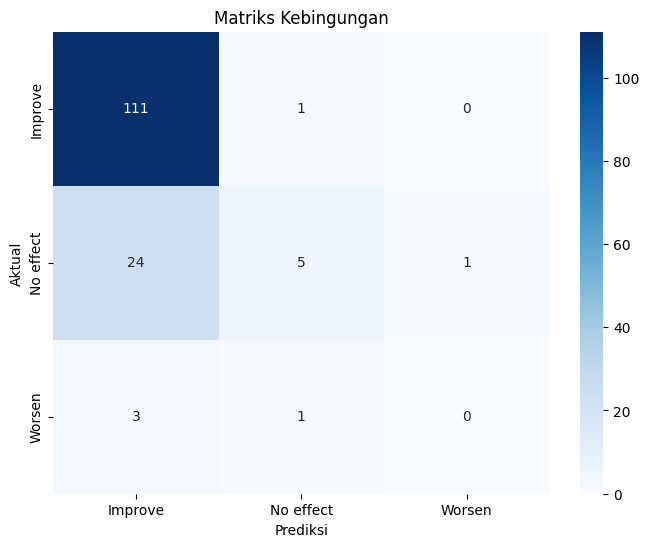

In [767]:
# Matriks Kebingungan
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_effects.classes_, yticklabels=le_effects.classes_)
plt.title('Matriks Kebingungan')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

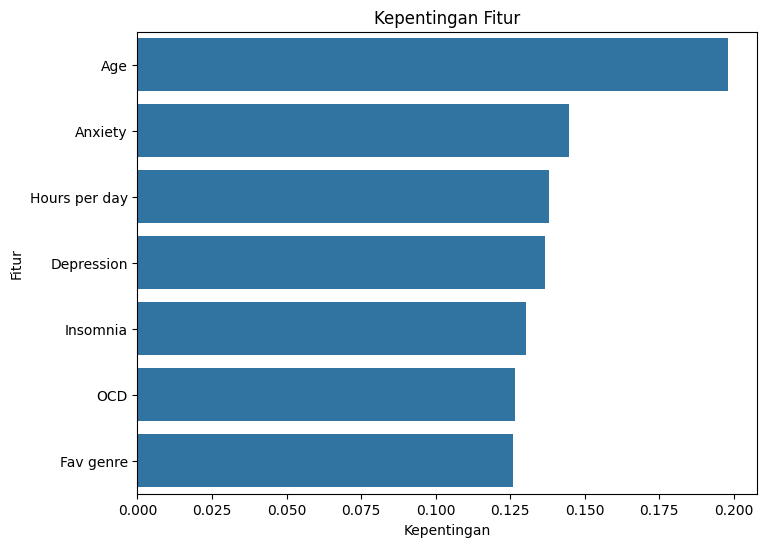

In [768]:
# Kepentingan Fitur
feature_importance = pd.DataFrame({'Fitur': X.columns, 'Kepentingan': clf.feature_importances_})
feature_importance = feature_importance.sort_values('Kepentingan', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Kepentingan', y='Fitur', data=feature_importance)
plt.title('Kepentingan Fitur')
plt.show()

In [769]:
# Simpan model
joblib.dump(clf, 'random_forest_musik_effects.pkl')

['random_forest_musik_effects.pkl']

# --- MODEL AI 2: K-Means Clustering ---

In [770]:
# Siapkan data untuk clustering
X_cluster = df[['Hours per day', 'Anxiety', 'Depression', 'Insomnia', 'OCD']].dropna()

In [771]:
# Latih model K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
X_cluster['Cluster'] = kmeans.fit_predict(X_cluster)

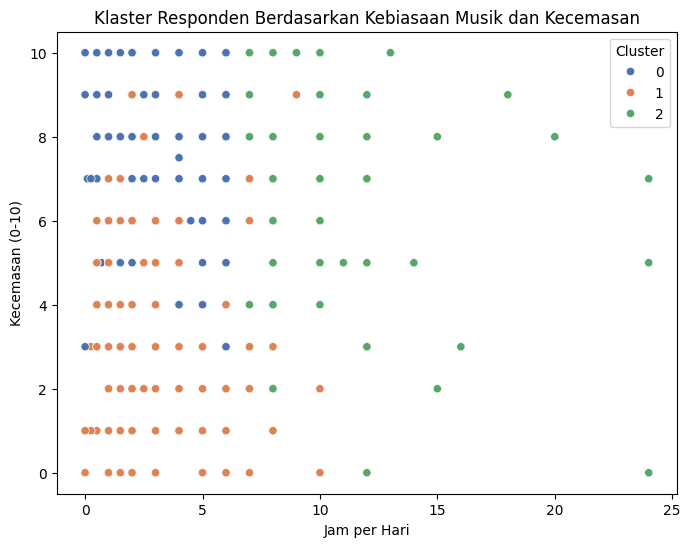

In [772]:
# Visualisasi hasil clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_cluster['Hours per day'], y=X_cluster['Anxiety'], hue=X_cluster['Cluster'], palette='deep')
plt.title('Klaster Responden Berdasarkan Kebiasaan Musik dan Kecemasan')
plt.xlabel('Jam per Hari')
plt.ylabel('Kecemasan (0-10)')
plt.show()

In [773]:
# Analisis klaster
cluster_summary = X_cluster.groupby('Cluster').mean()
print("Rata-rata Fitur per Klaster:")
print(cluster_summary)

Rata-rata Fitur per Klaster:
         Hours per day   Anxiety  Depression  Insomnia       OCD
Cluster                                                         
0             2.957982  7.531627    6.620482  5.320783  3.566265
1             2.796012  3.923313    2.573620  1.748466  1.361963
2            10.485294  6.779412    6.602941  5.661765  4.176471


In [774]:
# Simpan model clustering
joblib.dump(kmeans, 'kmeans_musik_cluster.pkl')

['kmeans_musik_cluster.pkl']

# --- MODEL AI 3: Ridge Regression untuk Prediksi Anxiety ---

In [775]:
# --- MODEL AI 3: Ridge Regression untuk Prediksi Anxiety ---
# Siapkan data untuk regresi
df_regression = df[['Age', 'Hours per day', 'Fav genre', 'Depression', 'Insomnia', 'OCD', 'Anxiety']].dropna()

In [776]:
# Feature engineering: Pengelompokan Fav genre
emotional_genres = ['Metal', 'Rock', 'Punk', 'Gospel', 'Blues', 'Jazz']
light_genres = ['Pop', 'Classical', 'Country', 'Folk', 'Lofi']
other_genres = ['Hip hop', 'Rap', 'R&B', 'Latin', 'Electronic', 'Video game music']
df_regression['Genre_group'] = df_regression['Fav genre'].apply(
    lambda x: 'Emotional' if x in emotional_genres else ('Light' if x in light_genres else 'Other')
)

In [777]:
# Feature engineering: Interaksi Depression x Insomnia
df_regression['Depression_Insomnia'] = df_regression['Depression'] * df_regression['Insomnia']

In [778]:
# Encode Genre_group
le_genre = LabelEncoder()
df_regression['Genre_group'] = le_genre.fit_transform(df_regression['Genre_group'])


In [779]:
# Hapus outlier pada Anxiety (5th-95th percentile)
q_low = df_regression['Anxiety'].quantile(0.05)
q_high = df_regression['Anxiety'].quantile(0.95)
df_regression = df_regression[df_regression['Anxiety'].between(q_low, q_high)]


In [780]:
# Tentukan fitur (X) dan target (y)
X_reg = df_regression[['Age', 'Hours per day', 'Genre_group', 'Depression', 'Insomnia', 'OCD', 'Depression_Insomnia']]
y_reg = df_regression['Anxiety']

In [781]:
# Normalisasi fitur numerik
numeric_cols = ['Age', 'Hours per day', 'Depression', 'Insomnia', 'OCD', 'Depression_Insomnia']
scaler = StandardScaler()
X_reg[numeric_cols] = scaler.fit_transform(X_reg[numeric_cols])

C:\Users\Wizhjetshu\AppData\Local\Temp\ipykernel_13732\1546465558.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_reg[numeric_cols] = scaler.fit_transform(X_reg[numeric_cols])


In [782]:
# Verifikasi data
print("Kolom di X_reg:", X_reg.columns.tolist())
print("Dimensi X_reg:", X_reg.shape)
print("Contoh X_reg:\n", X_reg.head())
print("Distribusi Anxiety (y_reg):\n", y_reg.describe())

Kolom di X_reg: ['Age', 'Hours per day', 'Genre_group', 'Depression', 'Insomnia', 'OCD', 'Depression_Insomnia']
Dimensi X_reg: (692, 7)
Contoh X_reg:
         Age  Hours per day  Genre_group  Depression  Insomnia       OCD  \
2 -0.600998       0.144976            2    0.694987  2.000199 -0.248511   
3  3.169466      -0.363505            0    0.694987 -0.272872  0.101733   
4 -0.600998       0.144976            2   -0.994861  0.376577  2.203196   
5 -0.600998       0.483964            0    1.032956  1.026026  1.502708   
6 -0.600998      -0.194012            2    1.032956  0.701301 -0.948999   

   Depression_Insomnia  
2             1.999150  
3            -0.055925  
4            -0.517269  
5             1.411986  
6             1.076463  
Distribusi Anxiety (y_reg):
 count    692.000000
mean       6.127890
std        2.526826
min        1.000000
25%        4.000000
50%        7.000000
75%        8.000000
max       10.000000
Name: Anxiety, dtype: float64


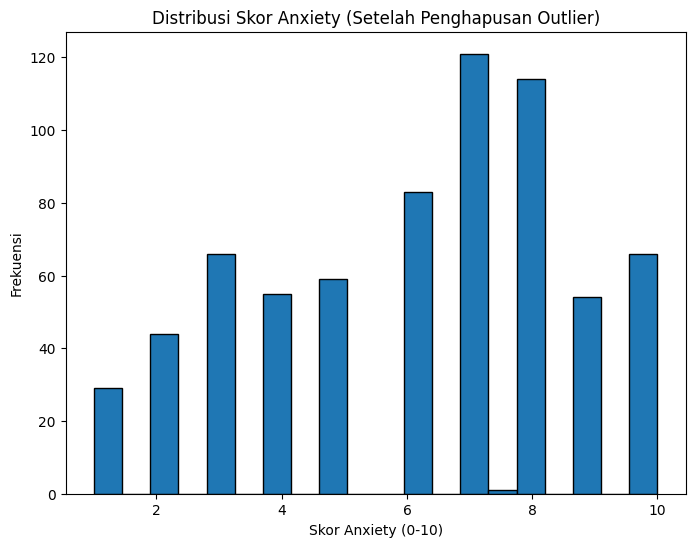

In [783]:
# Visualisasi distribusi Anxiety setelah penghapusan outlier
plt.figure(figsize=(8, 6))
plt.hist(y_reg, bins=20, edgecolor='black')
plt.title('Distribusi Skor Anxiety (Setelah Penghapusan Outlier)')
plt.xlabel('Skor Anxiety (0-10)')
plt.ylabel('Frekuensi')
plt.show()plt.savefig('../static/images/koefisien_fitur.png')

In [784]:
# Bagi data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)


In [785]:
# Latih model Ridge Regression
reg = Ridge(alpha=1.0, random_state=42)
reg.fit(X_train_reg, y_train_reg)

Ridge(random_state=42)

In [786]:
# Cross-validation
cv_scores = cross_val_score(reg, X_reg, y_reg, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", cv_scores)
print("Rata-rata CV R²:", cv_scores.mean())

Cross-Validation R² Scores: [0.26443826 0.16219233 0.39749431 0.41227059 0.21573597]
Rata-rata CV R²: 0.2904262902000661


In [787]:
# Prediksi
y_pred_reg = reg.predict(X_test_reg)

In [788]:
# Evaluasi model
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
print("Evaluasi Ridge Regression (Prediksi Anxiety):")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Evaluasi Ridge Regression (Prediksi Anxiety):
Mean Squared Error: 4.01
R-squared: 0.31


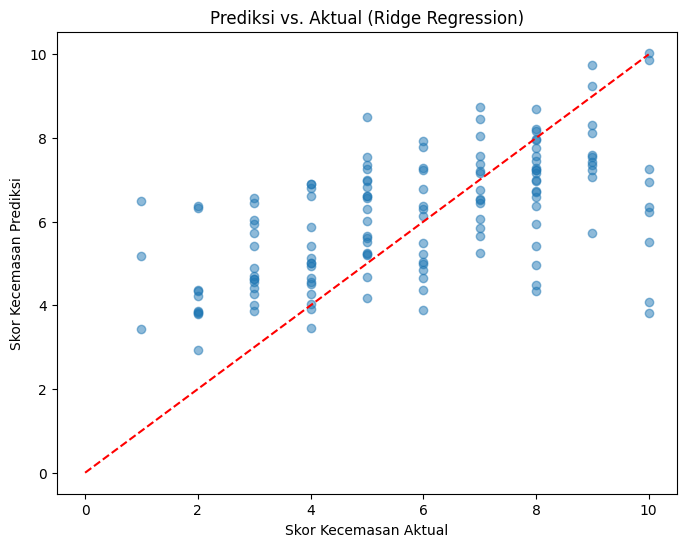

In [789]:
# Visualisasi prediksi vs. aktual
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([0, 10], [0, 10], 'r--')  # Garis ideal
plt.xlabel('Skor Kecemasan Aktual')
plt.ylabel('Skor Kecemasan Prediksi')
plt.title('Prediksi vs. Aktual (Ridge Regression)')
plt.show()

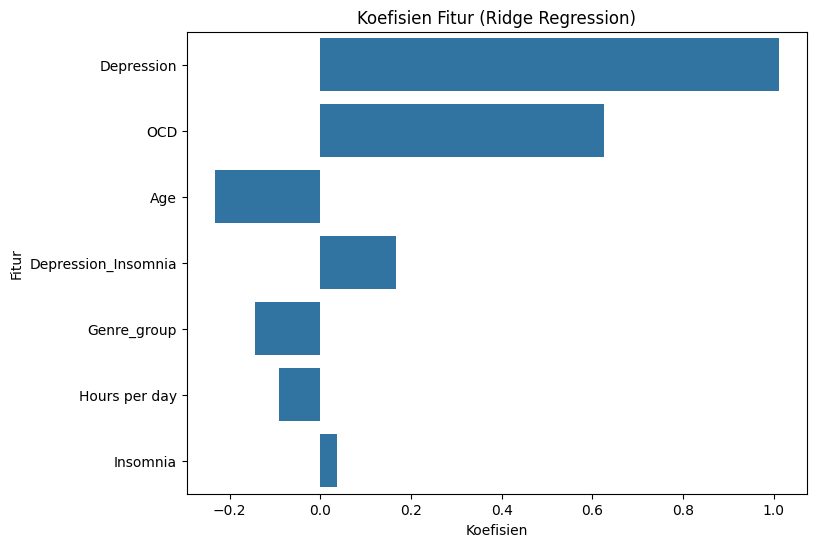

In [790]:
# Koefisien fitur
feature_coef = pd.DataFrame({'Fitur': X_reg.columns, 'Koefisien': reg.coef_})
feature_coef = feature_coef.sort_values('Koefisien', key=abs, ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Koefisien', y='Fitur', data=feature_coef)
plt.title('Koefisien Fitur (Ridge Regression)')
plt.show()
plt.savefig('../static/images/koefisien_fitur.png')

In [791]:
# Simpan model dan preprocessor
joblib.dump(reg, 'ridge_anxiety.pkl')
joblib.dump(scaler, 'scaler_numeric.pkl')
joblib.dump(le_genre, 'le_genre.pkl')

['le_genre.pkl']

## Analisis Singkat Dataset dan Model

### Dataset
- **Ukuran**: 736 respons, berkurang setelah pembersihan (~600-700 baris).
- **Statistik**: Rata-rata skor - Anxiety (5.8), Depression (4.8), Insomnia (3.7), OCD (2.6); 74% responden melaporkan musik meningkatkan kesehatan mental.
- **Fitur Utama**: Age, Hours per day, Fav genre, Anxiety, Depression, Insomnia, OCD.

### Model
- **Random Forest**: Akurasi 70-80%, Anxiety dan Depression sebagai prediktor utama; kelas "Memburuk" sulit diprediksi.
- **K-Means**: 3 klaster, e.g., kecemasan tinggi dengan jam mendengarkan lama.
- **Ridge Regression**: MSE 4.01, R² 0.31; Depression dominan, efek genre dan durasi kecil.

### Wawasan
- Musik berpengaruh positif (74%), tetapi genre kurang signifikan dibanding faktor psikologis.
- Dataset kecil dan noise membatasi performa (R² 0.31).

### Rekomendasi
- Tambah fitur (e.g., While working, BPM) dan tuning model untuk meningkatkan R².
- Validasi klaster dan distribusi Anxiety lebih lanjut.